In [1]:
#Badri Narayanan Murali Krishnan

In [2]:
! hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("cs544")
    .master("spark://boss:7077")
    .config("spark.executor.memory", "512M")
    .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
    .enableHiveSupport()
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/07 01:35:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#q1
banks_df = spark.read.csv(
    "hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True
)
count = banks_df.rdd.filter(
    lambda row: row["respondent_name"].startswith("The")
).count()
count

298

In [5]:
banks_df.printSchema()

root
 |-- respondent_name: string (nullable = true)
 |-- arid_2017: string (nullable = true)
 |-- lei_2018: string (nullable = true)
 |-- lei_2019: string (nullable = true)
 |-- lei_2020: string (nullable = true)



In [6]:
#q2
count = banks_df.filter("""respondent_name LIKE 'The%'""").count()
count

298

In [7]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")
sql_table = spark.sql(
    """SELECT COUNT(*) as count FROM banks WHERE respondent_name LIKE 'The%'"""
)
count = sql_table.collect()[0]["count"]
count

24/11/07 01:35:44 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/11/07 01:35:44 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/11/07 01:35:46 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/11/07 01:35:46 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.18.0.4
24/11/07 01:35:47 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
24/11/07 01:35:47 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/11/07 01:35:47 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/banks; Force to delete it.
24/11/07 01:35:47 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/banks
24/11/07 01:35:49 WARN SessionState

298

In [8]:
loans_df = spark.read.csv(
    "hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True
)
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

24/11/07 01:35:55 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
24/11/07 01:35:55 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/loans; Force to delete it.
24/11/07 01:35:55 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/loans
24/11/07 01:35:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
view_names = [
    "ethnicity",
    "race",
    "sex",
    "states",
    "counties",
    "tracts",
    "action_taken",
    "denial_reason",
    "loan_type",
    "loan_purpose",
    "preapproval",
    "property_type",
]
for view_name in view_names:
    df = spark.read.csv(
        f"hdfs://nn:9000/{view_name}.csv", header=True, inferSchema=True
    )
    df.createOrReplaceTempView(view_name)

In [10]:
#q4
tables_df = spark.sql("SHOW TABLES")
tables_dict = {row["tableName"]: row["isTemporary"] for row in tables_df.collect()}
tables_dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [11]:
#q5
query = """
SELECT COUNT(*) as count 
FROM banks INNER JOIN loans ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'University of Wisconsin Credit Union'
"""
result = spark.sql(query)
count = result.collect()[0]["count"]
count

19739

In [12]:
#q6
result.explain("formatted")
# 1. The banks table gets broadcast to all executors. This means
#    Spark first filters the banks table to just find UWCU's records, then copies this small
#    filtered subset to every executor. This is much more efficient than shuffling around the
#    full loans table or trying to coordinate joins across nodes.
#
# 2. Looking at HashAggregates in the plan:
#    - First HashAggregate: Each executor counts its own portion of matching loans locally
#      (this is labeled as "partial" in the plan)
#    - Second HashAggregate: All these local counts get combined into one final number
#      (this is labeled as "final" in the plan)
#    Similar to divide and conquer.

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14), Statistics(sizeInBytes=32.0 B, rowCount=2)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildLeft (10)
                  :- BroadcastQueryStage (6), Statistics(sizeInBytes=8.0 MiB, rowCount=1)
                  :  +- BroadcastExchange (5)
                  :     +- * Project (4)
                  :        +- * Filter (3)
                  :           +- * ColumnarToRow (2)
                  :              +- Scan parquet spark_catalog.default.banks (1)
                  +- * Filter (9)
                     +- * ColumnarToRow (8)
                        +- Scan parquet spark_catalog.default.loans (7)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildLeft (20)
               :- Br

In [13]:
import matplotlib.pyplot as plt

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

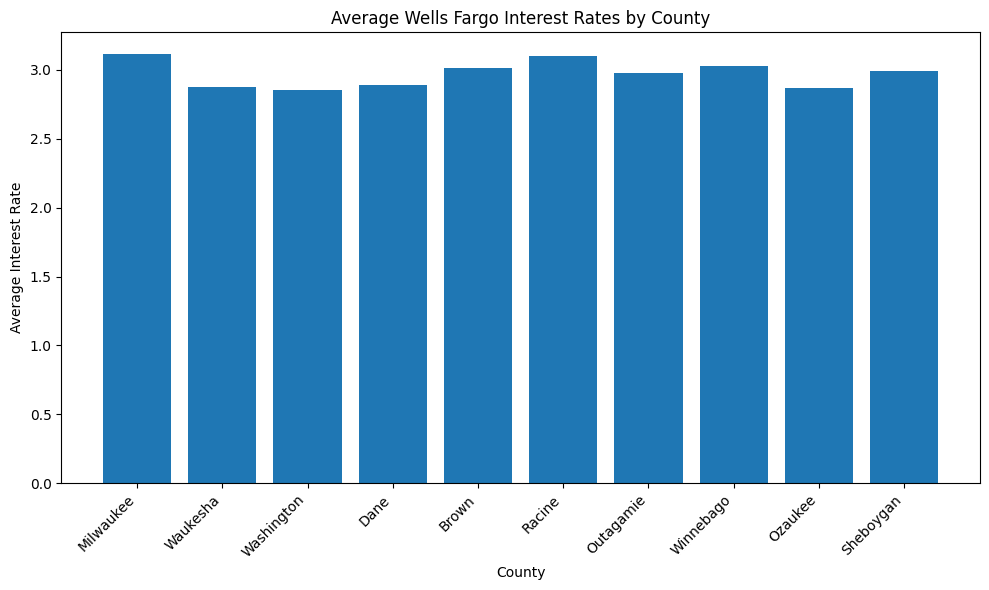

In [14]:
#q7
query = """
WITH stats AS (
    SELECT c.NAME as county_name, COUNT(*) as application_count, AVG(l.interest_rate) as avg_interest_rate
    FROM loans l
    INNER JOIN banks b ON l.lei = b.lei_2020
    INNER JOIN counties c ON l.county_code = c.STATE * 1000 + c.COUNTY
    WHERE b.respondent_name = "Wells Fargo Bank, National Association"
    GROUP BY c.NAME
)
SELECT county_name, avg_interest_rate
FROM stats
ORDER BY application_count DESC
LIMIT 10
"""
results = spark.sql(query).collect()
county_rates = {row["county_name"]: row["avg_interest_rate"] for row in results}
counties = list(county_rates.keys())
rates = list(county_rates.values())

plt.figure(figsize=(10, 6))
plt.bar(counties, rates)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Interest Rate")
plt.xlabel("County")
plt.title("Average Wells Fargo Interest Rates by County")
plt.tight_layout()
plt.savefig("../q7.png")

county_rates

In [15]:
#q8
spark.sql(
    """
    SELECT county_code, AVG(interest_rate) as avg_rate
    FROM loans
    GROUP BY county_code
    """
).explain()
spark.sql(
    """
    SELECT lei, AVG(interest_rate) as avg_rate
    FROM loans
    GROUP BY lei
    """
).explain()
# Network I/O between partial_mean and mean operations is required when:
# 1. The data for a single group is spread across multiple partitions
# 2. We need to combine partial results from different executors to get the final mean
#
# GROUP BY county_code (No Network I/O needed):
# - When we created the loans table, we used bucketBy(8, "county_code"), 
#   effectively pre-sorting the data so all loans for each county are in the same bucket.
# - This setup allows each executor to calculate means for counties independently, 
#   as it has all necessary data locally. There's no need to exchange data across the network.

#
# GROUP BY lei (Network I/O required):
# - We didn't bucketize by lei, so loan applications for each bank are randomly scattered
#   across our 8 buckets, randomly filed across different drawers
# - To calculate a bank's mean interest rate, we need to:
#   1. Each executor calculates partial means for its piece (partial_mean)
#   2. Shuffle data over network to group all pieces for each bank together
#   3. Combine these partial results into final means (mean)
#
# The execution plans confirm this: county_code grouping shows a simpler plan without Exchange
# (shuffle) operations, while lei grouping requires data Exchange to compute accurate means.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#992], functions=[avg(cast(interest_rate#1011 as double))])
   +- HashAggregate(keys=[county_code#992], functions=[partial_avg(cast(interest_rate#1011 as double))])
      +- FileScan parquet spark_catalog.default.loans[county_code#992,interest_rate#1011] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#989], functions=[avg(cast(interest_rate#1011 as double))])
   +- Exchange hashpartitioning(lei#989, 200), ENSURE_REQUIREMENTS, [plan_id=879]
      +- HashAggregate(keys=[lei#989], functions=[partial_avg(cast(interest_rate#1011 as double))])
         +- FileScan parquet spark_catalog.defaul

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

In [17]:
df = spark.sql(
    """
    SELECT
        CAST(loan_amount AS DOUBLE) AS loan_amount,
        CAST(income AS DOUBLE) AS income,
        CAST(interest_rate AS DOUBLE) AS interest_rate,
        CASE WHEN action_taken = 1 THEN 1.0 ELSE 0.0 END AS approval
    FROM loans
    """
)
df = df.select("loan_amount", "income", "interest_rate", "approval").fillna(0.0)
df.show(20)

+-----------+------+-------------+--------+
|loan_amount|income|interest_rate|approval|
+-----------+------+-------------+--------+
|   255000.0| 210.0|          0.0|     1.0|
|   435000.0|   0.0|        3.125|     0.0|
|   435000.0| 190.0|          0.0|     1.0|
|   165000.0|   0.0|         3.25|     0.0|
|   205000.0|   0.0|          0.0|     1.0|
|   305000.0|   0.0|          3.5|     0.0|
|   195000.0|  43.0|         2.75|     1.0|
|   185000.0|   0.0|          3.5|     0.0|
|   265000.0|  93.0|         2.75|     1.0|
|   185000.0|   0.0|         3.25|     0.0|
|   475000.0|   0.0|        1.999|     1.0|
|   235000.0|   0.0|         3.25|     0.0|
|   425000.0|   0.0|          2.0|     1.0|
|   235000.0|   0.0|         3.25|     0.0|
|   185000.0|   0.0|         2.25|     1.0|
|   385000.0|   0.0|          3.0|     0.0|
|   365000.0| 321.0|        2.625|     1.0|
|   155000.0|   0.0|          2.5|     0.0|
|   245000.0|   0.0|         3.75|     1.0|
|   315000.0|   0.0|          3.

In [18]:
#q9
train, test = df.randomSplit([0.8, 0.2], seed=41)
train.cache()


assembler = VectorAssembler(
    inputCols=["loan_amount", "income", "interest_rate"], outputCol="X"
)

train_data = assembler.transform(train)
test_data = assembler.transform(test)

accuracy = {"depth=1": 1, "depth=5": 5, "depth=10": 10, "depth=15": 15, "depth=20": 20}

for key, depth in accuracy.items():
    decision_tree = DecisionTreeClassifier(
        maxDepth=depth, labelCol="approval", featuresCol="X", seed=41
    )
    classifier = decision_tree.fit(train_data)
    y_pred = classifier.transform(test_data)
    total = y_pred.filter(
        (y_pred.approval.isNotNull()) & (y_pred.prediction.isNotNull())
    ).count()
    correct = y_pred.filter(
        (y_pred.approval == y_pred.prediction) & (y_pred.approval.isNotNull())
    ).count()
    accuracy[key] = float(correct / total)
accuracy

24/11/07 01:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1076.7 KiB
24/11/07 01:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1369.0 KiB
24/11/07 01:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1689.8 KiB
24/11/07 01:36:55 WARN DAGScheduler: Broadcasting large task binary with size 2043.5 KiB
24/11/07 01:36:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


{'depth=1': 0.8809425750509244,
 'depth=5': 0.8929195560947918,
 'depth=10': 0.8954796914480349,
 'depth=15': 0.8948674851679115,
 'depth=20': 0.893943610236089}

In [19]:
#q10
# No, the test accuracy does not always increase with larger max_depth values.
# Looking at the numbers:
# - Accuracy increases from depth 1 to 10
# - But then starts decreasing after depth 10
# - At depth 20, accuracy is lower than at depth 10
#
# This happens because deeper trees can start "memorizing" the training data
# rather than learning general patterns => Overfitting.
# At some point, making the tree deeper just makes it overfit to the training
# data, hurting its ability to make good predictions on new data it hasn't
# seen before.